- graphs starting quantities at zero
- graph prettiness
- store pvalues 
- conversation about type 1 and 2 errors
- ANOVA tukey graph, talk about CI
- Bonferroni correction

<img src='images/Northwind_ERD_updated.png.'>

<a href='#4.0-Initial-Question'>**4.0 Initial Question**</a>

<a href='#4.1-Initial-Hypothesis'>**4.1 Initial Hypothesis**</a>
- <a href='#4.1.1-Null-Hypothesis'>4.1.1 Null Hypothesis</a>
- <a href='#4.1.2-Alternative-Hypothesis'>4.1.2 Alternative Hypothesis</a>
- <a href='#4.1.3-Features'>4.1.3 Features</a>
- <a href='#4.1.4-Target-Variable'>4.1.4 Target Variable</a>

<a href='#4.2-Methodology'>**4.2 Methodology**</a>
- <a href='#4.2.1-Obtain-Data'>4.2.1 Obtain Data</a>
- <a href='#4.2.2-Scrub-Data'>4.2.2 Scrub Data</a>
    - <a href='#4.2.2.1-Manage-n/a-data-types'>4.2.2.1 Manage n/a data types</a>
    - <a href='#4.2.2.2-Remove-duplicate-data'>4.2.2.2 Remove duplicate data</a>
    - <a href='#4.2.2.3-Manage-data-types'>4.2.2.3 Manage data types</a>
    - <a href='#4.2.2.4-Remove-outliers'>4.2.2.4 Remove outliers</a>
- <a href='#4.2.3-Explore-Data'>4.2.3 Explore Data</a>
    - <a href='#4.2.3.1-Visualize-data'>4.2.3.1 Visualize data</a>
    - <a href='#4.2.3.2-Transform-data'>4.2.3.2 Transform data</a>
    - <a href='#4.2.3.3-Sort-data-/-Prepare-data-for-testing'>4.2.3.3 Sort data / Prepare data for testing</a>
    - <a href='#4.2.3.4-Develop-feature'>4.2.3.4 Develop feature</a>
- <a href='#4.2.4-Model-Data'>4.2.4 Model Data</a>
    - <a href='#4.2.4.1-Check-for-data-normality'>4.2.4.1 Check for data normality</a>
    - <a href='#4.2.4.2-Standard-deviation-and-other-basic-statistics'>4.2.4.2 Standard deviation and other basic statistics</a>
    - <a href='#4.2.4.3-Statistical-test'>4.2.4.3 Statistical test</a>
    - <a href='#4.2.4.4-Verification-techniques'>4.2.4.4 Verification techniques</a>
        - <a href='#4.2.4.4.1-Nonparametric-testing-and-confirmatory-testing'>4.2.4.4.1 Nonparametric testing</a>
        - <a href='#4.2.4.4.2-Effect-size'>4.2.4.4.2 Effect size</a>
        - <a href='#4.2.4.4.3-Error'>4.2.4.4.3 Error</a>
- <a href='#4.2.5-Interpret-Model'>4.2.5 Interpret Model</a>
    - <a href='#4.2.5.1-Extension-of-acquired-knowledge'>4.2.5.1 Extension of acquired knowledge</a>
    
<a href='#4.3-Results'>**4.3 Results**</a>

<a href='#4.4-Conclusions'>**4.4 Conclusions**</a>

- <a href='#4.4.1-Actionable-Items-and-Insights'>4.4.1 Actionable Items and Insights</a>
- <a href='#4.4.2-Additional-Visuals'>4.4.2 Additional Visuals</a>

<a href='#4.5-Future-Work'>**4.5 Future Work**</a>

<a href='#4.6-References'>**4.6 References**</a>

# 4.0 Initial Question<a id='Initial Question'></a>

Which region is preforming the best? How can we optimize preformance?


# 4.1 Initial Hypothesis<a id='Initial Hypothesis'></a>

### 4.1.1 Null Hypothesis<a id='Null Hypothesis'></a>
H0: no effect - Item total for specific regions is no different than that of all regions

The bolded items in the H0 statement represent the data that needs to be pulled down from the database. 

### 4.1.2 Alternative Hypothesis<a id='Alternative Hypothesis'></a>
HA: effect - Item total for specific regions is different than that of all regions

### 4.1.3 Features<a id='Features'></a>
: RegionId

### 4.1.4 Target Variable<a id='Target Variable'></a>
: OrderDetail.Quantity * OrderDetail.UnitPrice

# 4.2 Methodology<a id='Methodology'></a>

To evaluate, I have chosen to use the following steps:
- 4.2.1 Obtain Data
- 4.2.2 Scrub Data
- 4.2.3 Explore Data
- 4.2.4 Model Data
- 4.2.5 Interpret Model

I have found that the OSEMN method explains the data science process, and gives context to exploring data.

## 4.2.1 Obtain Data
The data that we're evaulating will come from the following tables.


put info in here

In [1]:
# develop class
pass

In [2]:
# import py file
from classes import Pvalue

In [3]:
# import libraries
import pandas as pd
import sqlite3

import numpy as np
from numpy import std, mean, sqrt
import scipy.stats as stats
from statsmodels.stats.power import tt_ind_solve_power
import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import folium

idx = pd.IndexSlice

In [4]:
# import data
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

In [5]:
# Territory data
cur.execute("""SELECT *
               FROM Territory
               """)
territory = pd.DataFrame(cur.fetchall())
territory.columns = [x[0] for x in cur.description]
territory.head()

,Id,TerritoryDescription,RegionId
0,01581,Westboro,1
1,01730,Bedford,1
2,01833,Georgetow,1
3,02116,Boston,1
4,02139,Cambridge,1


In [6]:
# Employee Territory
cur.execute("""SELECT *
               FROM EmployeeTerritory
               """)
employeeTerritory = pd.DataFrame(cur.fetchall())
employeeTerritory.columns = [x[0] for x in cur.description]
employeeTerritory.head()

,Id,EmployeeId,TerritoryId
0,1/06897,1,06897
1,1/19713,1,19713
2,2/01581,2,01581
3,2/01730,2,01730
4,2/01833,2,01833


In [7]:
# Employee data
cur.execute("""SELECT *
               FROM Employee
               """)
employee = pd.DataFrame(cur.fetchall())
employee.columns = [x[0] for x in cur.description]
employee.head()

,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,2024-08-14,908 W. Capital Way,Tacoma,North America,98401,USA,(206) 555-9482,3457,None,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp
2,3,Leverling,Janet,Sales Representative,Ms.,1995-08-30,2024-04-01,722 Moss Bay Blvd.,Kirkland,North America,98033,USA,(206) 555-3412,3355,None,Janet has a BS degree in chemistry from Boston...,2.0,http://accweb/emmployees/leverling.bmp
3,4,Peacock,Margaret,Sales Representative,Mrs.,1969-09-19,2025-05-03,4110 Old Redmond Rd.,Redmond,North America,98052,USA,(206) 555-8122,5176,None,Margaret holds a BA in English literature from...,2.0,http://accweb/emmployees/peacock.bmp
4,5,Buchanan,Steven,Sales Manager,Mr.,1987-03-04,2025-10-17,14 Garrett Hill,London,British Isles,SW1 8JR,UK,(71) 555-4848,3453,None,Steven Buchanan graduated from St. Andrews Uni...,2.0,http://accweb/emmployees/buchanan.bmp


In [8]:
# Order data
cur.execute("""SELECT *
               FROM 'Order'
               """)
order = pd.DataFrame(cur.fetchall())
order.columns = [x[0] for x in cur.description]
order.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [9]:
# OrderDetail data
cur.execute("""SELECT *
               FROM OrderDetail
               """)
orderDetail = pd.DataFrame(cur.fetchall())
orderDetail.columns = [x[0] for x in cur.description]
orderDetail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [10]:
# Import all data
cur.execute("""SELECT Territory.Id as TerritoryId, RegionId, EmployeeTerritory.EmployeeId, Employee.Region, Employee.LastName, 'Order'.Id, OrderDetail.ProductId, UnitPrice*Quantity as ItemTotal, UnitPrice, Quantity
               FROM Territory
               LEFT JOIN EmployeeTerritory ON Territory.Id = EmployeeTerritory.TerritoryId
               JOIN Employee on EmployeeTerritory.EmployeeId = Employee.Id
               JOIN 'Order' on Employee.Id = 'Order'.EmployeeId
               JOIN OrderDetail on 'Order'.Id = OrderDetail.OrderId
               """)
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df

,TerritoryId,RegionId,EmployeeId,Region,LastName,Id,ProductId,ItemTotal,UnitPrice,Quantity
0,01581,1,2,North America,Fuller,10265,17,936.0,31.20,30
1,01581,1,2,North America,Fuller,10265,70,240.0,12.00,20
2,01581,1,2,North America,Fuller,10277,28,728.0,36.40,20
3,01581,1,2,North America,Fuller,10277,62,472.8,39.40,12
4,01581,1,2,North America,Fuller,10280,24,43.2,3.60,12
...,...,...,...,...,...,...,...,...,...,...
10124,98104,2,6,British Isles,Suyama,11031,24,94.5,4.50,21
10125,98104,2,6,British Isles,Suyama,11031,64,665.0,33.25,20
10126,98104,2,6,British Isles,Suyama,11031,71,344.0,21.50,16
10127,98104,2,6,British Isles,Suyama,11045,33,37.5,2.50,15


## 4.2.2 Scrub Data<a id='Scrub Data'></a>

The following scrubbing techniques were applied to the original data:
- 4.2.2.1 Manage n/a data types
- 4.2.2.2 Remove duplicate rows
- 4.2.2.3 Manage data types
- 4.2.2.4 Remove outliers

### 4.2.2.1 Manage n/a data types

In [11]:
# nans identification
print(len(df))
df.isna().sum()

10129


TerritoryId    0
RegionId       0
EmployeeId     0
Region         0
LastName       0
Id             0
ProductId      0
ItemTotal      0
UnitPrice      0
Quantity       0
dtype: int64

### 4.2.2.2 Remove duplicate data

In [12]:
# identification of duplicate data
print('duplicated rows: ' + str(df.duplicated().sum()))

duplicated rows: 0


In [13]:
# code to drop duplicate row if necessary
df.drop_duplicates(inplace=True)
print('duplicated rows: ' + str(df.duplicated().sum()))

duplicated rows: 0


### 4.2.2.3 Manage data types

First, let's see what the data types for this data set are.

In [14]:
# data type identification
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10129 entries, 0 to 10128
Data columns (total 10 columns):
TerritoryId    10129 non-null object
RegionId       10129 non-null int64
EmployeeId     10129 non-null int64
Region         10129 non-null object
LastName       10129 non-null object
Id             10129 non-null int64
ProductId      10129 non-null int64
ItemTotal      10129 non-null float64
UnitPrice      10129 non-null float64
Quantity       10129 non-null int64
dtypes: float64(2), int64(5), object(3)
memory usage: 870.5+ KB


In [15]:
df.TerritoryId.unique()

array(['01581', '01730', '01833', '02116', '02139', '02184', '02903',
       '03049', '03801', '06897', '07960', '08837', '10019', '10038',
       '11747', '14450', '19428', '19713', '20852', '27403', '27511',
       '30346', '31406', '32859', '33607', '40222', '44122', '45839',
       '48075', '48084', '48304', '53404', '55113', '55439', '60179',
       '60601', '80202', '80909', '85014', '85251', '90405', '94025',
       '94105', '95008', '95054', '95060', '98004', '98052', '98104'],
      dtype=object)

In [16]:
df['TerritoryId'] = df['TerritoryId'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10129 entries, 0 to 10128
Data columns (total 10 columns):
TerritoryId    10129 non-null int32
RegionId       10129 non-null int64
EmployeeId     10129 non-null int64
Region         10129 non-null object
LastName       10129 non-null object
Id             10129 non-null int64
ProductId      10129 non-null int64
ItemTotal      10129 non-null float64
UnitPrice      10129 non-null float64
Quantity       10129 non-null int64
dtypes: float64(2), int32(1), int64(5), object(2)
memory usage: 830.9+ KB


In [17]:
df.Region.unique()

array(['North America', 'British Isles'], dtype=object)

In [18]:
df['Region'] = ['British_Isles' if x == 'British Isles' else 'North_America' for x in df['Region']]

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10129 entries, 0 to 10128
Data columns (total 10 columns):
TerritoryId    10129 non-null int32
RegionId       10129 non-null int64
EmployeeId     10129 non-null int64
Region         10129 non-null object
LastName       10129 non-null object
Id             10129 non-null int64
ProductId      10129 non-null int64
ItemTotal      10129 non-null float64
UnitPrice      10129 non-null float64
Quantity       10129 non-null int64
dtypes: float64(2), int32(1), int64(5), object(2)
memory usage: 830.9+ KB


In [20]:
df.Region.unique()

array(['North_America', 'British_Isles'], dtype=object)

In [21]:
df['Region'] = [str(x) for x in df['Region']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10129 entries, 0 to 10128
Data columns (total 10 columns):
TerritoryId    10129 non-null int32
RegionId       10129 non-null int64
EmployeeId     10129 non-null int64
Region         10129 non-null object
LastName       10129 non-null object
Id             10129 non-null int64
ProductId      10129 non-null int64
ItemTotal      10129 non-null float64
UnitPrice      10129 non-null float64
Quantity       10129 non-null int64
dtypes: float64(2), int32(1), int64(5), object(2)
memory usage: 830.9+ KB


In [22]:
df.columns

Index(['TerritoryId', 'RegionId', 'EmployeeId', 'Region', 'LastName', 'Id',
       'ProductId', 'ItemTotal', 'UnitPrice', 'Quantity'],
      dtype='object')

Observations about data types

### 4.2.2.4 Remove outliers

In [23]:
# outlier identification
pass

In [24]:
# management of outliers
pass

### Looking at the necessary data

## 4.2.3 Explore Data<a id='Explore Data'></a>

For a quick preview of what we have to work with, we'll use the describe method.

- 4.2.3.1 Visualize data
- 4.2.3.2 Transform data
- 4.2.3.3 Sort data / Prepare data for testing
- 4.2.3.4 Develop Feature

In [25]:
# describe data
df.describe()

,TerritoryId,RegionId,EmployeeId,Id,ProductId,ItemTotal,UnitPrice,Quantity
count,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000
mean,39445.883503,1.990226,4.884194,10663.762563,40.567874,661.287053,26.519361,24.343963
std,32149.598006,1.060010,2.468345,240.279728,22.098367,1122.766498,30.607125,19.410689
min,1581.000000,1.000000,1.000000,10248.000000,1.000000,4.800000,2.000000,1.000000
25%,10038.000000,1.000000,3.000000,10460.000000,22.000000,156.150000,12.000000,10.000000
50%,31406.000000,2.000000,5.000000,10659.000000,41.000000,372.000000,18.400000,20.000000
75%,60179.000000,3.000000,7.000000,10869.000000,60.000000,733.600000,32.800000,30.000000
max,98104.000000,4.000000,9.000000,11077.000000,77.000000,15810.000000,263.500000,130.000000


Observations about df.describe()

### 4.2.3.1 Visualize data

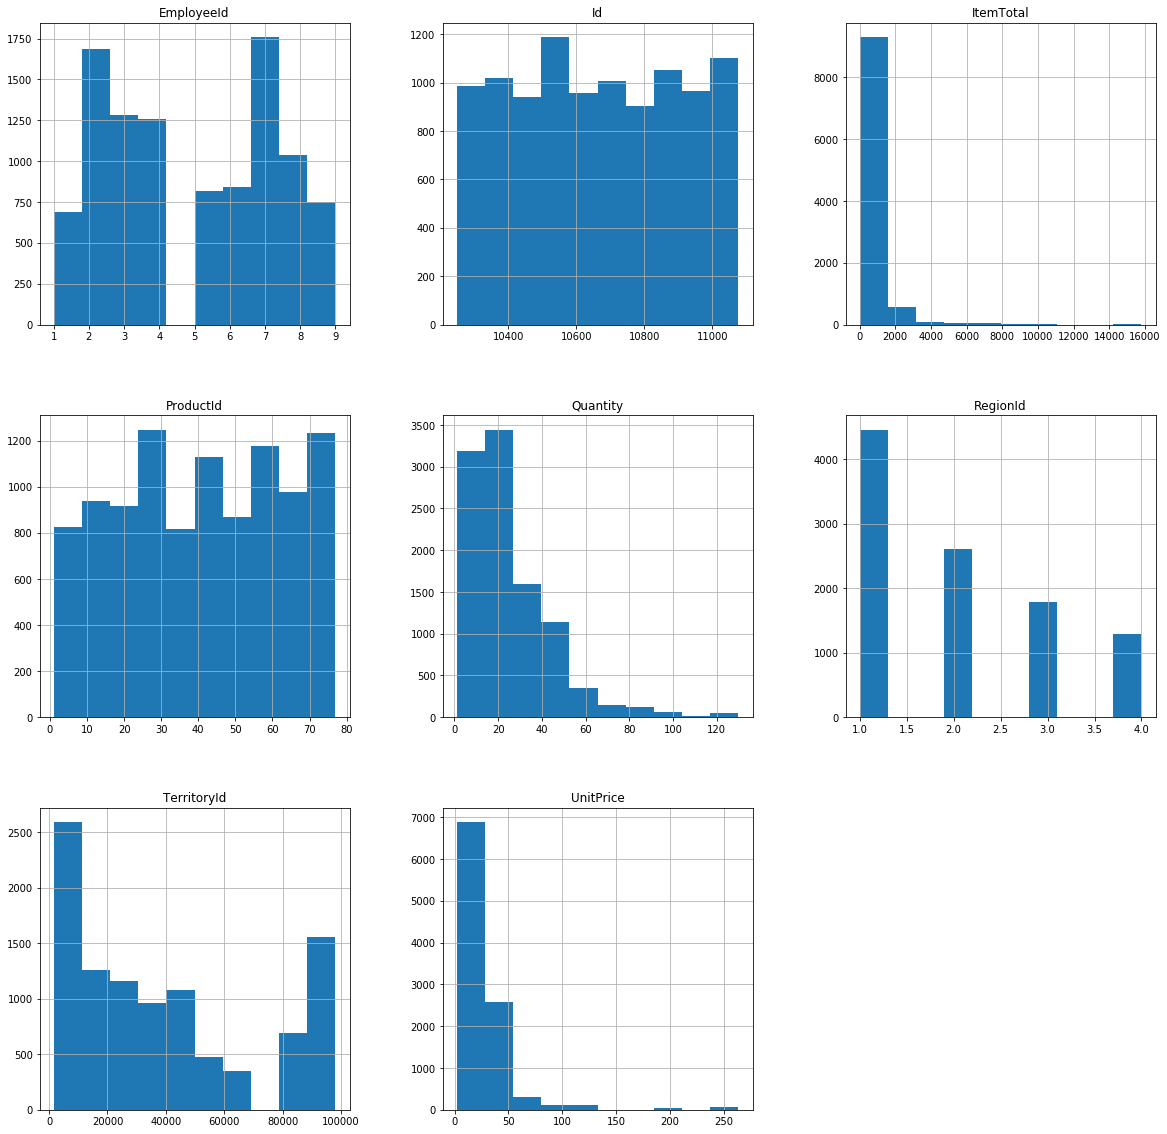

In [26]:
# visualize data
df.hist(figsize=(20,20));

### 4.2.3.2 Transform data

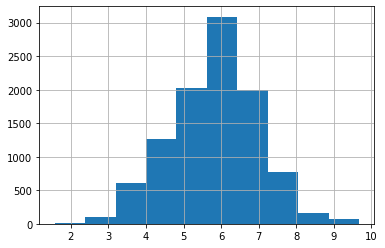

In [27]:
log = df.copy(deep=True)
log['ItemTotal'] = df['ItemTotal'].map(lambda x: np.log(x))
log['Quantity'] = df['Quantity'].map(lambda x: np.log(x))
log.ItemTotal.hist()

### 4.2.3.3 Sort data / Prepare data for testing

Plan and justification of sorting data

In [28]:
# sort data
pass

Observations about sorted data

### 4.2.3.4 Develop feature

In [29]:
# create features
pass

## 4.2.4 Model Data<a id='Model Data'></a>

- 1.2.4.1 Check for data normality
- 1.2.4.2 Standard deviation and other basic statistics
- 1.2.4.3 Statistical test
- 1.2.4.4 Verification techniques

### 4.2.4.1 Check for data normality

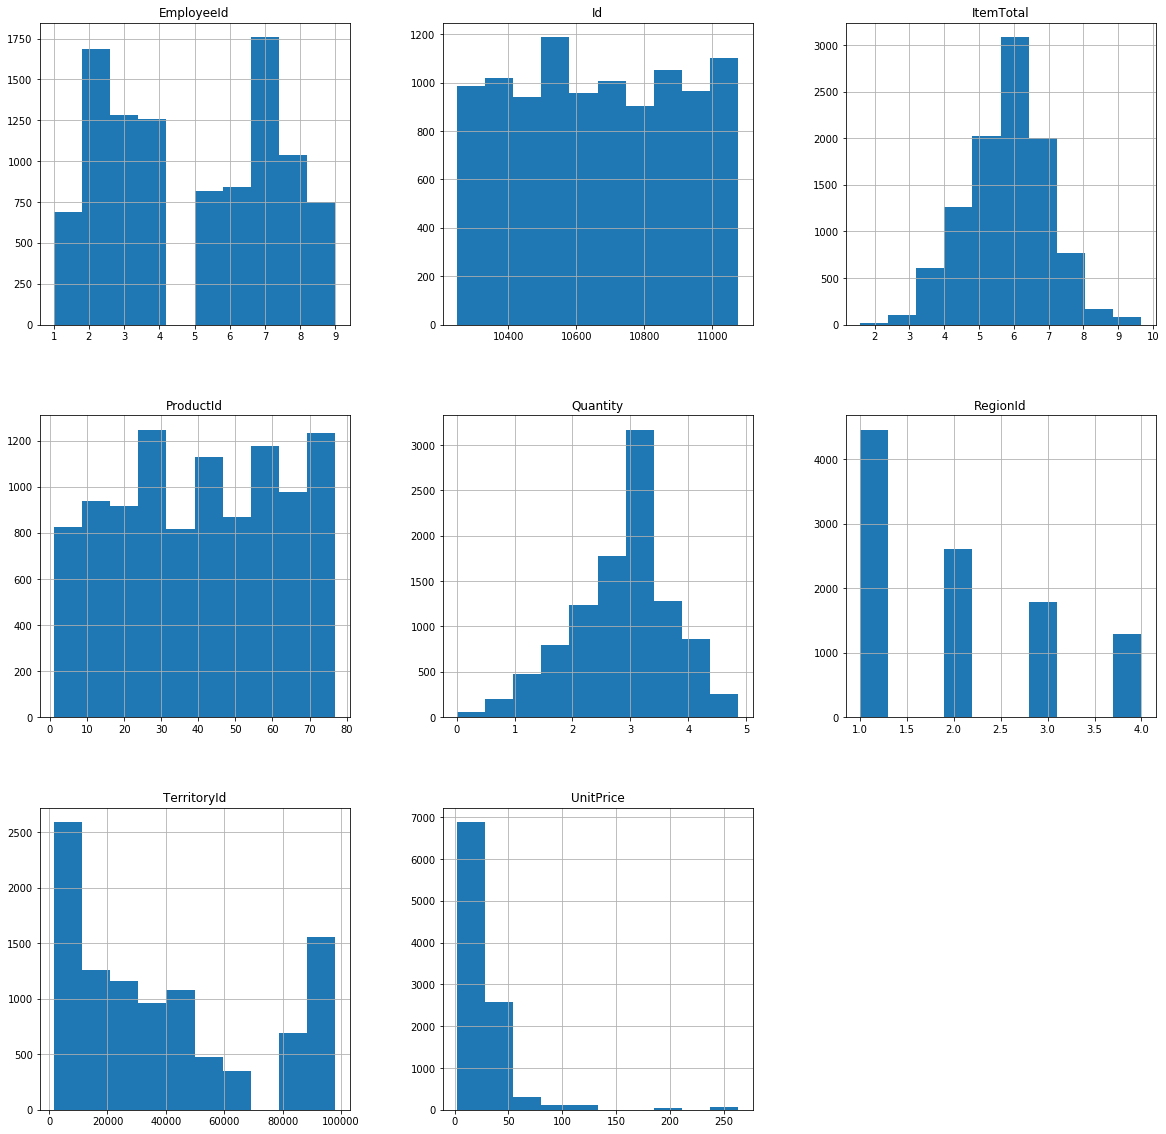

In [30]:
# visual/code for data normality
log.hist(figsize=(20,20));

### 4.2.4.2 Standard deviation and other basic statistics

In [31]:
# standard deviation for target variable
print('ItemTotal Population Measures of Variance')
print('numbers of samples: ' + str(len(log['ItemTotal'])))
print('population mean: ' + str(mean(log['ItemTotal'])))
print('population standard deviation: ' + str(std(log['ItemTotal'])))
print('population variance: ' + str(std(log['ItemTotal'])**2))
print('skew: ' + str(log['ItemTotal'].skew()))
print('Quantity Population Measures of Variance')
print('numbers of samples: ' + str(len(log['Quantity'])))
print('population mean: ' + str(mean(log['Quantity'])))
print('population standard deviation: ' + str(std(log['Quantity'])))
print('population variance: ' + str(std(log['Quantity'])**2))
print('skew: ' + str(log['Quantity'].skew()))

ItemTotal Population Measures of Variance
numbers of samples: 10129
population mean: 5.822359794298912
population standard deviation: 1.165811275166423
population variance: 1.3591159293051611
skew: -0.09461385082008122
Quantity Population Measures of Variance
numbers of samples: 10129
population mean: 2.874407680352321
population standard deviation: 0.8598564746203211
population variance: 0.739353156946487
skew: -0.5729028877668095


### 4.2.4.3 Statistical test

In [32]:
# set up variables for this particular test
alpha = 0.05
territoryId = [log[log['TerritoryId'] == x] for x in log['TerritoryId'].unique()]
len(territoryId)
x_bar_pop = log.ItemTotal.mean()
x_bar_sample = [x['ItemTotal'].mean() for x in territoryId]
sigma_pop = log.ItemTotal.std()
sigma_sample = [x['ItemTotal'].std() for x in territoryId]
n_pop = len(log.ItemTotal)
n_sample = [len(x['ItemTotal']) for x in territoryId]
mu_pop = mu_sample = 100
dof = [x-1 for x in n_sample]

In [33]:
# bonferroni correction
alpha_adj = alpha/(len(n_sample))
alpha_adj

0.0010204081632653062

In [34]:
# test
x_bar = np.array([x_bar_pop - i for i in x_bar_sample])
sigma = np.array([i**2 for i in sigma_sample])
sigma_per_sample = sigma / n_sample
t = ((x_bar) - (mu_pop-mu_sample)) / np.sqrt((sigma_pop**2/n_pop) + (sigma_per_sample))
dof_t = pd.DataFrame()
dof_t['dof'] = dof
dof_t['t'] = t

In [35]:
# result
p_value = 1-stats.t.cdf(dof_t['t'], dof_t['dof'])
p_value

array([0.68476546, 0.68476546, 0.68476546, 0.68476546, 0.68476546,
       0.68476546, 0.72187205, 0.71759218, 0.71759218, 0.00880333,
       0.72187205, 0.72187205, 0.72187205, 0.72187205, 0.72187205,
       0.72187205, 0.21202311, 0.00880333, 0.27060678, 0.27060678,
       0.27060678, 0.71619506, 0.71619506, 0.71619506, 0.71619506,
       0.68476546, 0.21202311, 0.21202311, 0.71759218, 0.71759218,
       0.71759218, 0.21202311, 0.71759218, 0.71759218, 0.85751959,
       0.85751959, 0.85751959, 0.85751959, 0.00686218, 0.00686218,
       0.85751959, 0.85751959, 0.85751959, 0.85751959, 0.85751959,
       0.85751959, 0.00686218, 0.00686218, 0.00686218])

In [87]:
# evaluation of result
for x,y in enumerate(p_value):
    if alpha > y:
        print(str(x) + ': Reject the null hypothesis')
    else:
        print(str(x) + ': Fail to reject the null hypothesis')

0: Fail to reject the null hypothesis
1: Fail to reject the null hypothesis
2: Fail to reject the null hypothesis
3: Fail to reject the null hypothesis
4: Fail to reject the null hypothesis
5: Fail to reject the null hypothesis
6: Fail to reject the null hypothesis
7: Fail to reject the null hypothesis
8: Fail to reject the null hypothesis
9: Reject the null hypothesis
10: Fail to reject the null hypothesis
11: Fail to reject the null hypothesis
12: Fail to reject the null hypothesis
13: Fail to reject the null hypothesis
14: Fail to reject the null hypothesis
15: Fail to reject the null hypothesis
16: Fail to reject the null hypothesis
17: Reject the null hypothesis
18: Fail to reject the null hypothesis
19: Fail to reject the null hypothesis
20: Fail to reject the null hypothesis
21: Fail to reject the null hypothesis
22: Fail to reject the null hypothesis
23: Fail to reject the null hypothesis
24: Fail to reject the null hypothesis
25: Fail to reject the null hypothesis
26: Fail to 

In [88]:
# evaluation of result with bonferroni correction
for x,y in enumerate(p_value):
    if alpha_adj > y:
        print(str(x) + ': Reject the null hypothesis')
    else:
        print(str(x) + ': Fail to reject the null hypothesis')

0: Fail to reject the null hypothesis
1: Fail to reject the null hypothesis
2: Fail to reject the null hypothesis
3: Fail to reject the null hypothesis
4: Fail to reject the null hypothesis
5: Fail to reject the null hypothesis
6: Fail to reject the null hypothesis
7: Fail to reject the null hypothesis
8: Fail to reject the null hypothesis
9: Fail to reject the null hypothesis
10: Fail to reject the null hypothesis
11: Fail to reject the null hypothesis
12: Fail to reject the null hypothesis
13: Fail to reject the null hypothesis
14: Fail to reject the null hypothesis
15: Fail to reject the null hypothesis
16: Fail to reject the null hypothesis
17: Fail to reject the null hypothesis
18: Fail to reject the null hypothesis
19: Fail to reject the null hypothesis
20: Fail to reject the null hypothesis
21: Fail to reject the null hypothesis
22: Fail to reject the null hypothesis
23: Fail to reject the null hypothesis
24: Fail to reject the null hypothesis
25: Fail to reject the null hypothe

In [37]:
# variables for quantity
x_bar_pop = log.Quantity.mean()
x_bar_sample = [x['Quantity'].mean() for x in territoryId]
sigma_pop = log.Quantity.std()
sigma_sample = [x['Quantity'].std() for x in territoryId]
n_pop = len(log.Quantity)
n_sample = [len(x['Quantity']) for x in territoryId]
mu_pop = mu_sample = 100
dof = [x-1 for x in n_sample]

In [38]:
# tests for quantity
x_bar = np.array([x_bar_pop - i for i in x_bar_sample])
sigma = np.array([i**2 for i in sigma_sample])
sigma_per_sample = sigma / n_sample
t = ((x_bar) - (mu_pop-mu_sample)) / np.sqrt((sigma_pop**2/n_pop) + (sigma_per_sample))
dof_t = pd.DataFrame()
dof_t['dof'] = dof
dof_t['t'] = t

In [39]:
# results for quantity
p_value = 1-stats.t.cdf(dof_t['t'], dof_t['dof'])
p_value

array([0.53239871, 0.53239871, 0.53239871, 0.53239871, 0.53239871,
       0.53239871, 0.93952233, 0.69486033, 0.69486033, 0.00149569,
       0.93952233, 0.93952233, 0.93952233, 0.93952233, 0.93952233,
       0.93952233, 0.30183705, 0.00149569, 0.16568705, 0.16568705,
       0.16568705, 0.69938616, 0.69938616, 0.69938616, 0.69938616,
       0.53239871, 0.30183705, 0.30183705, 0.69486033, 0.69486033,
       0.69486033, 0.30183705, 0.69486033, 0.69486033, 0.87918113,
       0.87918113, 0.87918113, 0.87918113, 0.02595722, 0.02595722,
       0.87918113, 0.87918113, 0.87918113, 0.87918113, 0.87918113,
       0.87918113, 0.02595722, 0.02595722, 0.02595722])

In [86]:
# evaluation of result for quantity
for x,y in enumerate(p_value):
    if alpha > y:
        print(str(x) + ': Reject the null hypothesis')
    else:
        print(str(x) + ': Fail to reject the null hypothesis')

0: Fail to reject the null hypothesis
1: Fail to reject the null hypothesis
2: Fail to reject the null hypothesis
3: Fail to reject the null hypothesis
4: Fail to reject the null hypothesis
5: Fail to reject the null hypothesis
6: Fail to reject the null hypothesis
7: Fail to reject the null hypothesis
8: Fail to reject the null hypothesis
9: Reject the null hypothesis
10: Fail to reject the null hypothesis
11: Fail to reject the null hypothesis
12: Fail to reject the null hypothesis
13: Fail to reject the null hypothesis
14: Fail to reject the null hypothesis
15: Fail to reject the null hypothesis
16: Fail to reject the null hypothesis
17: Reject the null hypothesis
18: Fail to reject the null hypothesis
19: Fail to reject the null hypothesis
20: Fail to reject the null hypothesis
21: Fail to reject the null hypothesis
22: Fail to reject the null hypothesis
23: Fail to reject the null hypothesis
24: Fail to reject the null hypothesis
25: Fail to reject the null hypothesis
26: Fail to 

In [90]:
# evaluation of result for quantity with bonferroni correction
for x,y in enumerate(p_value):
    if alpha_adj > y:
        print(str(x) + ': Reject the null hypothesis')
    else:
        print(str(x) + ': Fail to reject the null hypothesis')

0: Fail to reject the null hypothesis
1: Fail to reject the null hypothesis
2: Fail to reject the null hypothesis
3: Fail to reject the null hypothesis
4: Fail to reject the null hypothesis
5: Fail to reject the null hypothesis
6: Fail to reject the null hypothesis
7: Fail to reject the null hypothesis
8: Fail to reject the null hypothesis
9: Fail to reject the null hypothesis
10: Fail to reject the null hypothesis
11: Fail to reject the null hypothesis
12: Fail to reject the null hypothesis
13: Fail to reject the null hypothesis
14: Fail to reject the null hypothesis
15: Fail to reject the null hypothesis
16: Fail to reject the null hypothesis
17: Fail to reject the null hypothesis
18: Fail to reject the null hypothesis
19: Fail to reject the null hypothesis
20: Fail to reject the null hypothesis
21: Fail to reject the null hypothesis
22: Fail to reject the null hypothesis
23: Fail to reject the null hypothesis
24: Fail to reject the null hypothesis
25: Fail to reject the null hypothe

In [41]:
# For Region's 7, 8, 9, 10, 11, 26, 27
territory_85014 = territoryId[7]
territory_85251 = territoryId[8]
territory_98004 = territoryId[9]
territory_98052 = territoryId[10]
territory_98104 = territoryId[11]
territory_06897 = territoryId[26]
territory_19713 = territoryId[27]

In [42]:
territory_85014

,TerritoryId,RegionId,EmployeeId,Region,LastName,Id,ProductId,ItemTotal,UnitPrice,Quantity
1563,3049,3,9,British_Isles,Dodsworth,10255,2,5.717028,15.2,2.995732
1564,3049,3,9,British_Isles,Dodsworth,10255,16,6.187237,13.9,3.555348
1565,3049,3,9,British_Isles,Dodsworth,10255,36,5.940171,15.2,3.218876
1566,3049,3,9,British_Isles,Dodsworth,10255,59,7.185387,44.0,3.401197
1567,3049,3,9,British_Isles,Dodsworth,10263,16,6.726233,13.9,4.094345
...,...,...,...,...,...,...,...,...,...,...
1665,3049,3,9,British_Isles,Dodsworth,11022,19,5.774552,9.2,3.555348
1666,3049,3,9,British_Isles,Dodsworth,11022,69,6.984716,36.0,3.401197
1667,3049,3,9,British_Isles,Dodsworth,11058,21,3.401197,10.0,1.098612
1668,3049,3,9,British_Isles,Dodsworth,11058,60,6.570883,34.0,3.044522


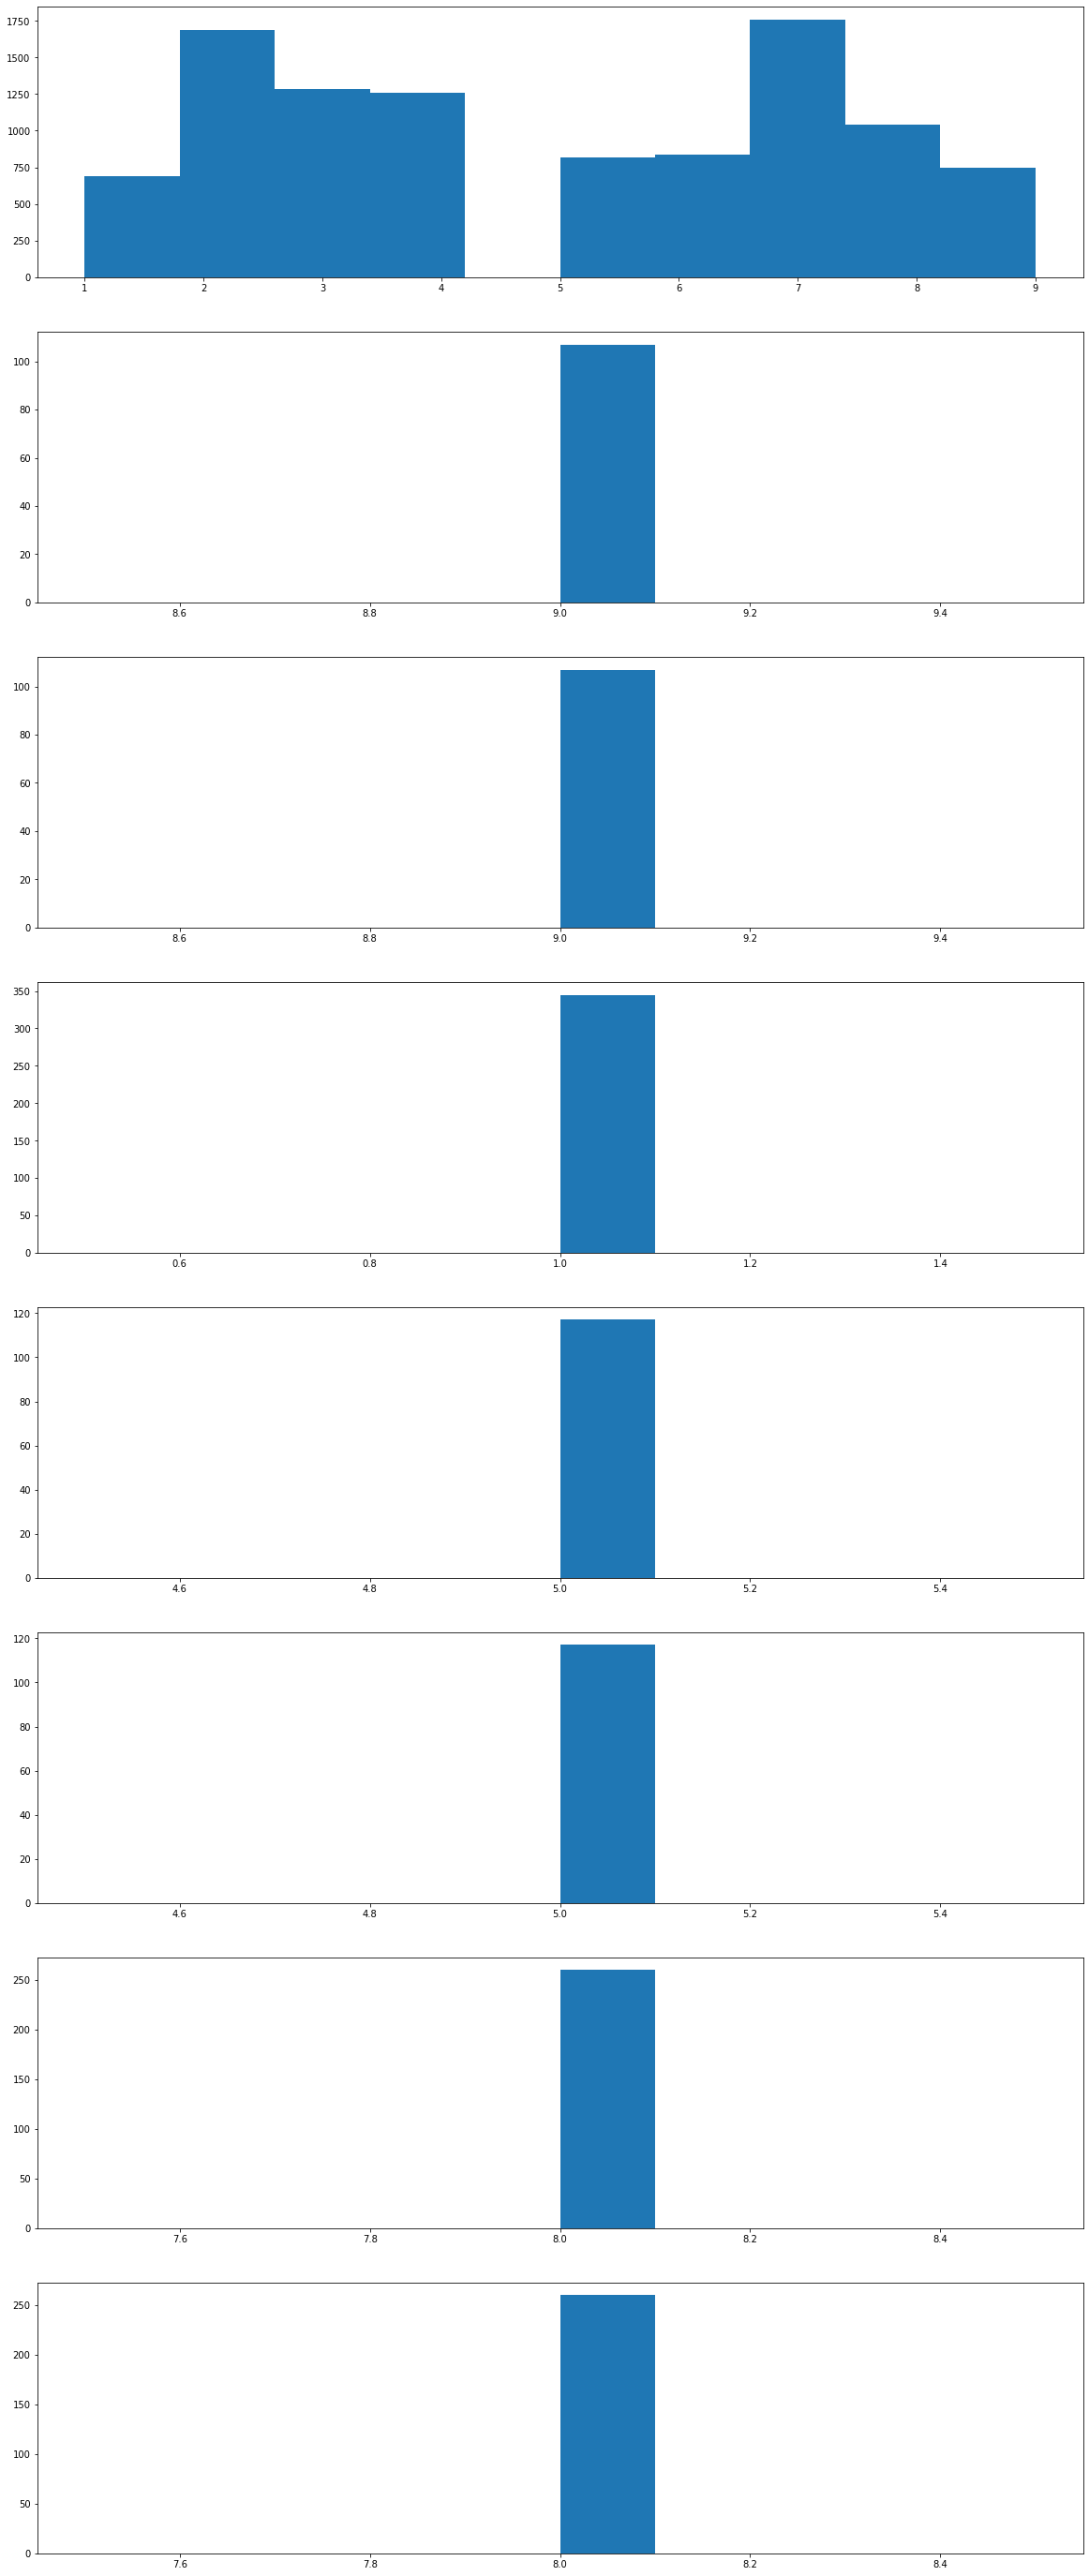

In [43]:
fig00 = plt.figure(figsize=(20,50))
ax = fig00.add_subplot(811)
ax1 = plt.hist(log['EmployeeId'])
ax = fig00.add_subplot(812)
ax2 = plt.hist(territory_85014['EmployeeId'])
ax = fig00.add_subplot(813)
ax3 = plt.hist(territory_85251['EmployeeId'])
ax = fig00.add_subplot(814)
ax4 = plt.hist(territory_98004['EmployeeId'])
ax = fig00.add_subplot(815)
ax5 = plt.hist(territory_98052['EmployeeId'])
ax = fig00.add_subplot(816)
ax6 = plt.hist(territory_98104['EmployeeId'])
ax = fig00.add_subplot(817)
ax7 = plt.hist(territory_06897['EmployeeId'])
ax = fig00.add_subplot(818)
ax8 = plt.hist(territory_19713['EmployeeId']);

In [44]:
data_to_join = [territory_85014, territory_85251, territory_98004, territory_98052, 
                territory_98104, territory_06897, territory_19713]
different = pd.concat(data_to_join)
different

,TerritoryId,RegionId,EmployeeId,Region,LastName,Id,ProductId,ItemTotal,UnitPrice,Quantity
1563,3049,3,9,British_Isles,Dodsworth,10255,2,5.717028,15.2,2.995732
1564,3049,3,9,British_Isles,Dodsworth,10255,16,6.187237,13.9,3.555348
1565,3049,3,9,British_Isles,Dodsworth,10255,36,5.940171,15.2,3.218876
1566,3049,3,9,British_Isles,Dodsworth,10255,59,7.185387,44.0,3.401197
1567,3049,3,9,British_Isles,Dodsworth,10263,16,6.726233,13.9,4.094345
...,...,...,...,...,...,...,...,...,...,...
6729,45839,3,8,North_America,Callahan,11068,43,7.412160,46.0,3.583519
6730,45839,3,8,North_America,Callahan,11068,77,5.897154,13.0,3.332205
6731,45839,3,8,North_America,Callahan,11075,2,5.247024,19.0,2.302585
6732,45839,3,8,North_America,Callahan,11075,46,5.886104,12.0,3.401197


In [45]:
territory['Id']

0     01581
1     01730
2     01833
3     02116
4     02139
5     02184
6     02903
7     03049
8     03801
9     06897
10    07960
11    08837
12    10019
13    10038
14    11747
15    14450
16    19428
17    19713
18    20852
19    27403
20    27511
21    29202
22    30346
23    31406
24    32859
25    33607
26    40222
27    44122
28    45839
29    48075
30    48084
31    48304
32    53404
33    55113
34    55439
35    60179
36    60601
37    72716
38    75234
39    78759
40    80202
41    80909
42    85014
43    85251
44    90405
45    94025
46    94105
47    95008
48    95054
49    95060
50    98004
51    98052
52    98104
Name: Id, dtype: object

In [46]:
successful_territories = []
successful_territories.append(territory[territory['Id'] == '85014']['TerritoryDescription'])
successful_territories.append(territory[territory['Id'] == '85251']['TerritoryDescription'])
successful_territories.append(territory[territory['Id'] == '98004']['TerritoryDescription'])
successful_territories.append(territory[territory['Id'] == '98052']['TerritoryDescription'])
successful_territories.append(territory[territory['Id'] == '98104']['TerritoryDescription'])
successful_territories.append(territory[territory['Id'] == '06897']['TerritoryDescription'])
successful_territories.append(territory[territory['Id'] == '19713']['TerritoryDescription'])
successful_territories

[42    Phoenix
 Name: TerritoryDescription, dtype: object, 43    Scottsdale
 Name: TerritoryDescription, dtype: object, 50    Bellevue
 Name: TerritoryDescription, dtype: object, 51    Redmond
 Name: TerritoryDescription, dtype: object, 52    Seattle
 Name: TerritoryDescription, dtype: object, 9    Wilton
 Name: TerritoryDescription, dtype: object, 17    Neward
 Name: TerritoryDescription, dtype: object]

In [47]:
successful_cities = ['Phoenix', 'Scottsdale', 'Bellevue', 'Redmond', 'Seattle', 'Wilton', 'Neward']
len(successful_cities)

7

In [48]:
successful_people = different['LastName'].unique()
successful_people

array(['Dodsworth', 'Davolio', 'Buchanan', 'Callahan'], dtype=object)

In [49]:
# map regions
successful_zips = [(33.448376,-112.074036), (33.494171,-111.926048), (47.610149,-122.201515), (47.673988,-122.121513),
                   (47.606209,-122.332069), (54.235130,-0.682000), (55.487810,-4.602750)]

# map generation
successful_zip_map = folium.Map(location=(59.136499, -27.829387), zoom_start = 2)

# addition of significant zipcode data
popup_phoenix = 'Phoenix'
marker_phoenix = folium.Marker(successful_zips[0], popup=popup_phoenix, icon=folium.Icon(color='green'))
popup_scottsdale = 'Scottsdale'
marker_scottsdale = folium.Marker(successful_zips[1], popup=popup_scottsdale, icon=folium.Icon(color='green'))
popup_Bellevue = 'Bellevue'
marker_Bellevue = folium.Marker(successful_zips[2], popup=popup_Bellevue, icon=folium.Icon(color='green'))
popup_Redmond = 'Redmond'
marker_Redmond = folium.Marker(successful_zips[3], popup=popup_Redmond, icon=folium.Icon(color='green'))
popup_Seattle = 'Seattle'
marker_Seattle = folium.Marker(successful_zips[4], popup=popup_Seattle, icon=folium.Icon(color='green'))
popup_Wilton = 'Wilton'
marker_Wilton = folium.Marker(successful_zips[5], popup=popup_Wilton, icon=folium.Icon(color='green'))
popup_Neward = 'Bellevue'
marker_Neward = folium.Marker(successful_zips[6], popup=popup_Neward, icon=folium.Icon(color='green'))

# populate zipcode data onto map
successful_zip_map.add_child(marker_phoenix)
successful_zip_map.add_child(marker_scottsdale)
successful_zip_map.add_child(marker_Bellevue)
successful_zip_map.add_child(marker_Redmond)
successful_zip_map.add_child(marker_Seattle)
successful_zip_map.add_child(marker_Wilton)
successful_zip_map.add_child(marker_Neward)

#save map
successful_zip_map.save('locations where item total is higher than everywhere else.html')

# display map
successful_zip_map

In [50]:
sm.stats.anova_lm(ols('ItemTotal ~ TerritoryId + RegionId + LastName', data=different).fit())

,df,sum_sq,mean_sq,F,PR(>F)
LastName,3.0,1.017291e+01,3.390969e+00,2.613093e+00,0.049907
TerritoryId,1.0,5.048710e-29,5.048710e-29,3.890554e-29,1.000000
RegionId,1.0,1.283523e+00,1.283523e+00,9.890876e-01,0.320149
Residual,1308.0,1.697371e+03,1.297684e+00,NaN,NaN


Summarize results and determine next steps. Might include verification of sample size, error types, non-parametric testing, or a deepening of understanding

### 4.2.4.4 Verification techniques
#### 4.2.4.4.1 Nonparametric testing and confirmatory testing<a id='Nonparametric testing'></a>
##### Nonparametric testing

In [51]:
# non-parametric testing variables
pass

In [52]:
# non-parametric test
pass

In [53]:
# result
pass

In [54]:
# evaluation of results
pass

Oberservations based on new finding

##### Confirmatory testing

In [55]:
# confirmatory test 
pass

Oberservations based on new finding

#### 4.2.4.4.2 Effect size<a id='Effect size'></a>
Cohen's D

In [56]:
# effect size variables
pass

In [57]:
# effect size test
def cohen_d_one_samp(x, mu0):
    mu = mean(x)
    sample_std = std(x, ddof=1)
    return (mu - mu0) / sample_std
def cohen_d_two_samp(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)
# effect_size = cohen_d_two_samp('', '')
# effect_size

Obeservations about effect size

#### 4.2.4.4.3 Error<a id='Error'></a>

In [58]:
# power variables
pass

In [59]:
# power test

In [60]:
# evaluation of power test

Observations about power test

### Cross validatation

In [61]:
# test train split or resampling for testing preformed above
pass

## 4.2.5 Interpret Model<a id='Interpret Model'></a>

### 4.2.5.1 Extension of acquired knowledge<a id='Extension'></a>
#### Deeper question
#### Hypothesis for deeper question

In [62]:
# deeper understanding variables
pass

In [63]:
# deeper understanding test
pass

In [64]:
# deeper understanding result
pass

In [65]:
# deeper understanding evaluation of result
pass

Observations based off of deeper understanding test

# 4.3 Results<a id='Results'></a>

Conclusions about question overall commentary on hypothesis

# 4.4 Conclusions<a id='Conclusions'></a>

- 4.4.1 Actionable Items and Insights
- 4.4.2 Additional Visuals

## 4.4.1 Actionable Items and Insights<a id='Actionable Items and Insights'></a>

## 4.4.2 Additional Visuals

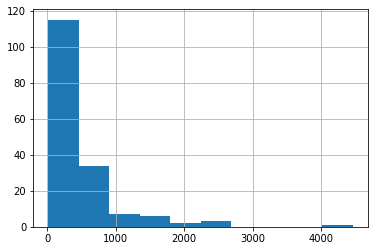

In [66]:
# visual for blah blah blah
df[df['TerritoryId'] == 85014]['ItemTotal'].hist()

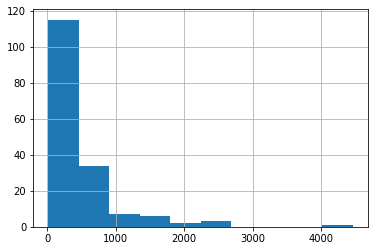

In [67]:
df[df['TerritoryId'] == 85251]['ItemTotal'].hist()

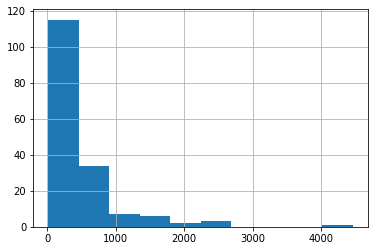

In [68]:
df[df['TerritoryId'] == 98004]['ItemTotal'].hist()

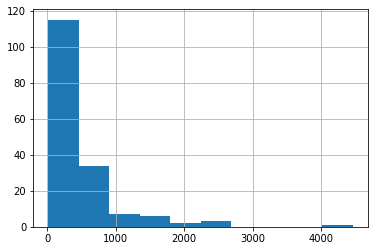

In [69]:
df[df['TerritoryId'] == 98052]['ItemTotal'].hist()

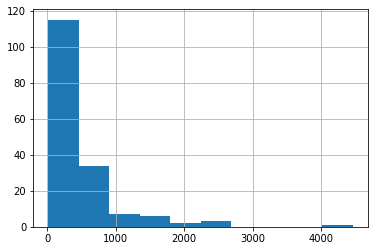

In [70]:
df[df['TerritoryId'] == 98104]['ItemTotal'].hist()

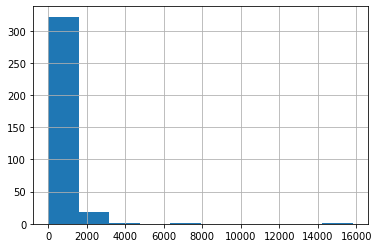

In [71]:
df[df['TerritoryId'] == 6897]['ItemTotal'].hist()

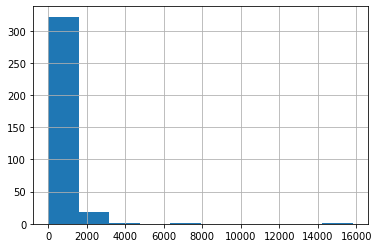

In [72]:
df[df['TerritoryId'] == 19713]['ItemTotal'].hist()

In [73]:
employee[employee['Id'] == 6]

,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
5,6,Suyama,Michael,Sales Representative,Mr.,1995-07-02,2025-10-17,Coventry House Miner Rd.,London,British Isles,EC2 7JR,UK,(71) 555-7773,428,None,Michael is a graduate of Sussex University (MA...,5.0,http://accweb/emmployees/davolio.bmp


In [74]:
employee[employee['Id'] == 1]

,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp


In [75]:
employee_work = df.groupby(['LastName', 'Id', 'ProductId']).mean()
employee_work

TerritoryId  RegionId  EmployeeId  ItemTotal  \
LastName Id    ProductId                                                 
Buchanan 10248 11              9422.0         1           5      168.0   
               42              9422.0         1           5       98.0   
               72              9422.0         1           5      174.0   
         10254 24              9422.0         1           5       54.0   
               55              9422.0         1           5      403.2   
...                               ...       ...         ...        ...   
Suyama   11031 24             92885.0         2           6       94.5   
               64             92885.0         2           6      665.0   
               71             92885.0         2           6      344.0   
         11045 33             92885.0         2           6       37.5   
               51             92885.0         2           6     1272.0   

                          UnitPrice  Quantity  
LastName Id    ProductId                       
Buchanan 10248 11             14.00        12  
               42              9.80        10  
               72             34.80         5  
         10254 24              3.60        15  
               55             19.20        21  
...                             ...       ...  
Suyama   11031 24              4.50        21  
               64             33.25        20  
               71             21.50        16  
         11045 33              2.50        15  
               51             53.00        24  

[2155 rows x 6 columns]

In [76]:
employees = df['LastName'].unique()
employees

array(['Fuller', 'Buchanan', 'Dodsworth', 'Davolio', 'Callahan',
       'Peacock', 'Leverling', 'King', 'Suyama'], dtype=object)

### Tools for use of discovered information

In [ ]:
# function or equation used to test developed theories
pass

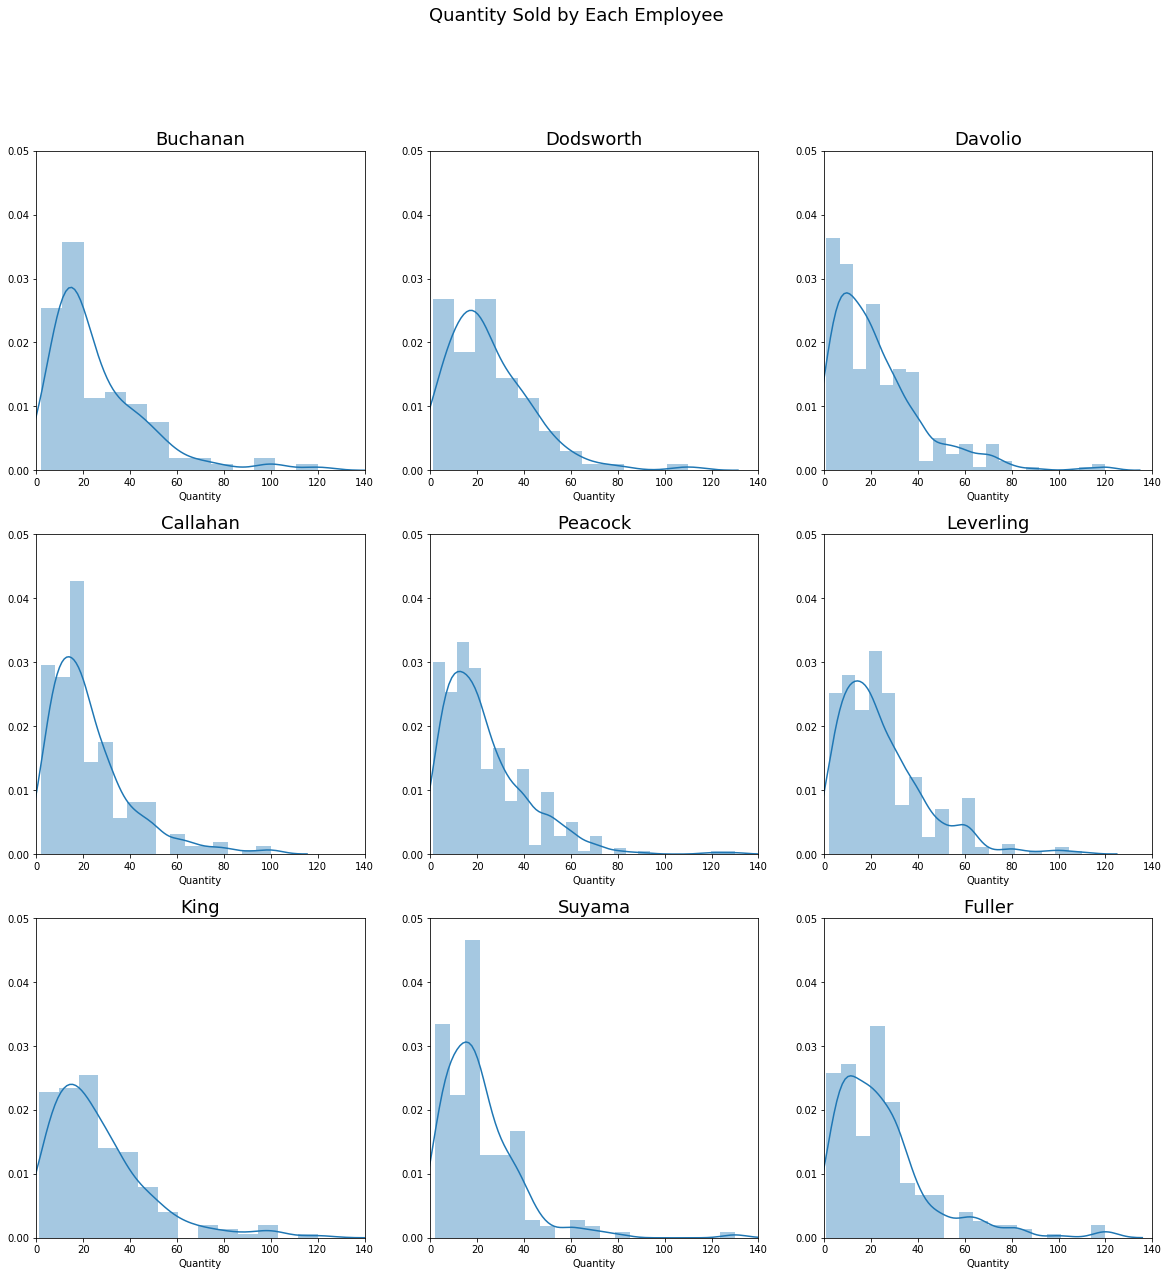

In [84]:
x = [employee_work.loc[idx[i]]['Quantity'] for i in employees]
fig05, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,20))
for n in range(0, len(employees)):
    row = (n-1)//3
    col = n%3-1
    ax = axes[row][col]
    sns.distplot(x[n], ax=ax).set_xlim(left=0, right=140)
    ax.set_ylim(ymax=0.05)
    ax.set_title('{}'.format(employees[n]), fontsize=18)
fig05.suptitle('Quantity Sold by Each Employee', fontsize=18);

# 4.5 Future Work<a id='Future Work'></a>

Investigate deeper into work done by territory.
Set sales goals that focus on lower quantities of product sold with high frequency.

# 4.6 References<a id='References'></a>

Measure skewness https://towardsdatascience.com/understanding-measures-of-variance-with-python-f57d59617a0b
Lat/Long: https://www.latlong.net/